In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import numpy as np
import cv2

import matplotlib.pyplot as plt
import time

import onnxruntime
from Module.sam.utils.transforms import ResizeLongestSide
from torch.nn import functional as F

C:\Users\danusys16\anaconda3\envs\yolov8\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
C:\Users\danusys16\anaconda3\envs\yolov8\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
D:\015_segmentation\Custom_SAM\Module\sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with Module.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
D:\015_segmentation\Custom_SAM\Module\sam\modeling\tiny_vit_sam.py:656: UserWarning: Over

## Model

In [3]:
EP_list = ['CPUExecutionProvider']

### Encoder

In [4]:
enc_path = "../runs/241120_vit_t_to_resnet18_DANU_WS_v2_01/tiny_vit_best_encoder.onnx" ## 경량모델
#enc_path = "../runs/241119_vit-b_to_vit-t_DANU_WS_v2/tiny_vit_best_encoder.onnx"
#enc_path = "../runs/241115_SAM_ViT_b_dataset_V2_ft_v1\\best_encoder.onnx" ## 무거운 모델

In [5]:
enc_session = onnxruntime.InferenceSession(enc_path, providers=EP_list)

### Decoder

In [6]:
dec_path = "../runs/241115_SAM_ViT_b_dataset_V2_ft_v1/best.onnx"

In [7]:
dec_session = onnxruntime.InferenceSession(dec_path, providers=EP_list)

## Data

### Load image

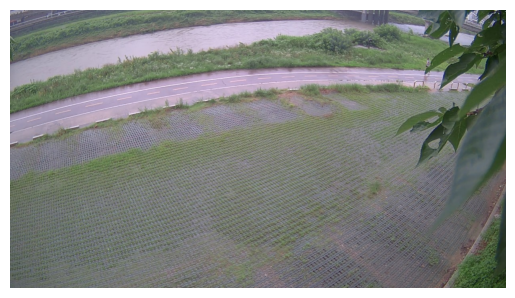

In [8]:
img_path = "../images/AY05.jpg"
ori_img = cv2.imread(img_path)
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
original_size = ori_img.shape

plt.imshow(ori_img)
plt.axis('off');

### Pre_process

In [11]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

def pre_process(img):
    enc_input_size = 1024
    transform = ResizeLongestSide(enc_input_size)
    pixel_mean = torch.Tensor([123.675, 116.28, 103.53]).view(-1, 1, 1)
    pixel_std = torch.Tensor([58.395, 57.12, 57.375]).view(-1, 1, 1)

    input_img = transform.apply_image(img)
    
    input_img = torch.as_tensor(input_img)
    input_img = input_img.permute(2, 0, 1).contiguous()[None, :, :, :]

    ## Optional
    ## ResNet이면 사용
    ## ViT 계열이면 사용X
    input_img = (input_img - pixel_mean) / pixel_std

    h, w = input_img.shape[-2:]
    padh = enc_input_size - h
    padw = enc_input_size - w
    
    input_img = F.pad(input_img, (0, padw, 0, padh))
    return input_img

In [12]:
a= time.time()

## 전처리
input_img = pre_process(ori_img)

## 인코더 실행
b= time.time()
enc_input = {enc_session.get_inputs()[0].name: to_numpy(input_img)}
image_embedding = enc_session.run(None, enc_input)
print("인코더만 실행:",time.time()-b)

## 디코더 실행
c = time.time()
onnx_coord = np.concatenate([np.array([[0.0, 0.0]])], axis=0)[None, :, :].astype(np.float32)
onnx_label = np.concatenate([np.array([-1])], axis=0)[None, :].astype(np.float32)
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)
        
dec_inputs = {
    "image_embeddings": image_embedding[0],
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(original_size[:2]).astype(np.int32)}
masks, _, _ = dec_session.run(None, dec_inputs)
binary_mask = (masks[0][0, :, :] > 0).astype(np.float32)
print("디코더만 실행:",time.time()-c)
print("전체 실행:",time.time()-a)

인코더만 실행: 0.14300060272216797
디코더만 실행: 0.061998844146728516
전체 실행: 0.2219996452331543


### Visualization

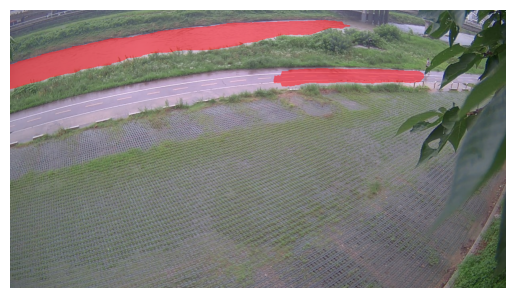

In [13]:
seg_img = ori_img.copy()
seg_img[binary_mask==1] = (255,0,0)
transparent_img = cv2.addWeighted(ori_img,0.5,seg_img,0.5,1.0)
plt.imshow(transparent_img)
plt.axis('off');